In [2]:
#use the shadowcar dataset to accelerate training process
!wget "https://github.com/pseudodream/nerf_project/blob/main/simple_data.npz?raw=True" -O data.npz

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

--2024-05-04 17:38:34--  https://github.com/airalcorn2/pytorch-nerf/blob/master/66bdbc812bd0a196e194052f3f12cb2e.npz?raw=True
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/airalcorn2/pytorch-nerf/raw/master/66bdbc812bd0a196e194052f3f12cb2e.npz [following]
--2024-05-04 17:38:35--  https://github.com/airalcorn2/pytorch-nerf/raw/master/66bdbc812bd0a196e194052f3f12cb2e.npz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/airalcorn2/pytorch-nerf/master/66bdbc812bd0a196e194052f3f12cb2e.npz [following]
--2024-05-04 17:38:35--  https://raw.githubusercontent.com/airalcorn2/pytorch-nerf/master/66bdbc812bd0a196e194052f3f12cb2e.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Conne

In [2]:
!wget "https://github.com/pseudodream/nerf_project/blob/main/simple_data.npz?raw=True" -O data.npz

zsh:1: command not found: wget


In [8]:



#get the points along the ray using ray directions (ray_dir),ray origins (ray_origin),
def get_coarse_query_points(ray_dir, N_c, t_i_c_bin_edges, t_i_c_gap, ray_origin):
    u_is_c = torch.rand(*list(ray_dir.shape[:2]) + [N_c]).to(ray_dir)

    t_is_c = t_i_c_bin_edges + u_is_c * t_i_c_gap
    r_ts_c = ray_origin[..., None, :] + t_is_c[..., :, None] * ray_dir[..., None, :]
    return (r_ts_c, t_is_c)


#get fine query points from ray directions (ray_dir),ray origins (ray_origin), sampled depths (t_is_c)
def get_fine_query_points(w_is_c, N_f, t_is_c, t_f, ray_origin, ray_dir):

    # Define PDFs (pdfs) and CDFs (cdfs) from weights (w_is_c).
    w_is_c = w_is_c + 1e-5
    pdfs = w_is_c / torch.sum(w_is_c, dim=-1, keepdim=True)
    cdfs = torch.cumsum(pdfs, dim=-1)
    cdfs = torch.cat([torch.zeros_like(cdfs[..., :1]), cdfs[..., :-1]], dim=-1)

    # Get uniform samples (us).
    us = torch.rand(list(cdfs.shape[:-1]) + [N_f]).to(w_is_c)

    # Use inverse inverse transform sampling to sample the depths (t_is_f).
    idxs = torch.searchsorted(cdfs, us, right=True)
    t_i_f_bottom_edges = torch.gather(t_is_c, 2, idxs - 1)
    idxs_capped = idxs.clone()
    max_ind = cdfs.shape[-1]
    idxs_capped[idxs_capped == max_ind] = max_ind - 1
    t_i_f_top_edges = torch.gather(t_is_c, 2, idxs_capped)
    t_i_f_top_edges[idxs == max_ind] = t_f
    t_i_f_gaps = t_i_f_top_edges - t_i_f_bottom_edges
    u_is_f = torch.rand_like(t_i_f_gaps).to(ray_origin)
    t_is_f = t_i_f_bottom_edges + u_is_f * t_i_f_gaps

    # Combine the coarse (t_is_c) and fine (t_is_f) depths and sort them.
    (t_is_f, _) = torch.sort(torch.cat([t_is_c, t_is_f.detach()], dim=-1), dim=-1)
    r_ts_f = ray_origin[..., None, :] + t_is_f[..., :, None] * ray_dir[..., None, :]
    return (r_ts_f, t_is_f)

#radiance volume rendering to get color abd weights
def render_radiance_volume(r_ts, ray_dir, chunk_size, F, t_is):

    r_ts_flat = r_ts.reshape((-1, 3))
    ray_dir_rep = ray_dir.unsqueeze(2).repeat(1, 1, r_ts.shape[-2], 1)
    ray_dir_flat = ray_dir_rep.reshape((-1, 3))
    c_is = []
    sigma_is = []
    for chunk_start in range(0, r_ts_flat.shape[0], chunk_size):
        r_ts_batch = r_ts_flat[chunk_start : chunk_start + chunk_size]
        ray_dir_batch = ray_dir_flat[chunk_start : chunk_start + chunk_size]
        preds = F(r_ts_batch, ray_dir_batch)
        c_is.append(preds["c_is"])
        sigma_is.append(preds["sigma_is"])

    c_is = torch.cat(c_is).reshape(r_ts.shape)
    sigma_is = torch.cat(sigma_is).reshape(r_ts.shape[:-1])


    delta_is = t_is[..., 1:] - t_is[..., :-1]

    one_e_10 = torch.Tensor([1e10]).expand(delta_is[..., :1].shape)
    delta_is = torch.cat([delta_is, one_e_10.to(delta_is)], dim=-1)
    delta_is = delta_is * ray_dir.norm(dim=-1).unsqueeze(-1)

    # Calculate the alphas (alpha_is) of the 3D points using the volume densities
    alpha_is = 1.0 - torch.exp(-sigma_is * delta_is)

    T_is = torch.cumprod(1.0 - alpha_is + 1e-10, -1)
    T_is = torch.roll(T_is, 1, -1)
    T_is[..., 0] = 1.0

    # Calculate the weights (w_is) for the colors (c_is) along the rays using the
    # transmittances (T_is) and alphas (alpha_is). See Equation (5) in Section 5.2:
    # w_i = T_i * (1 - exp(-sigma_i * delta_i)).
    w_is = T_is * alpha_is

    # Calculate the pixel colors (C_rs) for the rays as weighted (w_is) sums of colors
    C_rs = (w_is[..., None] * c_is).sum(dim=-2)

    return (C_rs, w_is)


def run_nerf(
    ray_dir, N_c, t_i_c_bin_edges, t_i_c_gap, ray_origin, chunk_size, F_c, N_f, t_f, F_f
):
    (r_ts_c, t_is_c) = get_coarse_query_points(ray_dir, N_c, t_i_c_bin_edges, t_i_c_gap, ray_origin)
    (C_rs_c, w_is_c) = render_radiance_volume(r_ts_c, ray_dir, chunk_size, F_c, t_is_c)

    (r_ts_f, t_is_f) = get_fine_query_points(w_is_c, N_f, t_is_c, t_f, ray_origin, ray_dir)
    (C_rs_f, _) = render_radiance_volume(r_ts_f, ray_dir, chunk_size, F_f, t_is_f)

    return (C_rs_c, C_rs_f)


class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        # 10 encoding functions for positions
        self.L_pos = 10
        # 4 encoding functions for viewing directions
        self.L_dir = 4
        pos_enc_feats = 3 + 3 * 2 * self.L_pos
        dir_enc_feats = 3 + 3 * 2 * self.L_dir

        in_feats = pos_enc_feats
        net_width = 256
        #pos_mlp: mlp that takes pos encoding, it outputs density
        pos_mlp_layers = 5
        pos_mlp = []

        for layer_idx in range(pos_mlp_layers):
            pos_mlp.append(nn.Linear(in_feats, net_width))
            pos_mlp.append(nn.ReLU())
            in_feats = net_width

        self.pos_mlp = nn.Sequential(*pos_mlp)

        in_feats = pos_enc_feats + net_width
        #dir_mlp: mlp that take output pos_mlp + dir encoding, it outputs color RGB
        dir_mlp_layers = 3
        dir_mlp = []
        for layer_idx in range(dir_mlp_layers):
            dir_mlp.append(nn.Linear(in_feats, net_width))
            dir_mlp.append(nn.ReLU())
            in_feats = net_width

        self.dir_mlp = nn.Sequential(*dir_mlp)
        self.sigma_layer = nn.Linear(net_width, net_width + 1)
        self.concat_layer = nn.Sequential(
            nn.Linear(dir_enc_feats + net_width, net_width // 2), nn.ReLU()
        )
        self.color_layer = nn.Sequential(nn.Linear(net_width // 2, 3), nn.Sigmoid())

    def forward(self, xs, ray_dir):
        xs_encoded = [xs]
        for l_pos in range(self.L_pos):
            xs_encoded.append(torch.sin(2 ** l_pos * torch.pi * xs))
            xs_encoded.append(torch.cos(2 ** l_pos * torch.pi * xs))

        xs_encoded = torch.cat(xs_encoded, dim=-1)

        ray_dir = ray_dir / ray_dir.norm(p=2, dim=-1).unsqueeze(-1)
        ray_dir_encoded = [ray_dir]
        for l_dir in range(self.L_dir):
            ray_dir_encoded.append(torch.sin(2 ** l_dir * torch.pi * ray_dir))
            ray_dir_encoded.append(torch.cos(2 ** l_dir * torch.pi * ray_dir))

        ray_dir_encoded = torch.cat(ray_dir_encoded, dim=-1)

        outputs = self.pos_mlp(xs_encoded)
        outputs = self.dir_mlp(torch.cat([xs_encoded, outputs], dim=-1))
        outputs = self.sigma_layer(outputs)
        sigma_is = torch.relu(outputs[:, 0])
        outputs = self.concat_layer(torch.cat([ray_dir_encoded, outputs[:, 1:]], dim=-1))
        c_is = self.color_layer(outputs)
        return {"c_is": c_is, "sigma_is": sigma_is}

NpzFile '66bdbc812bd0a196e194052f3f12cb2e.npz' with keys: images, poses, focal, camera_distance

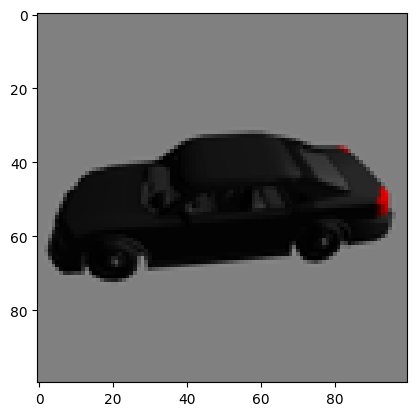

MLP(
  (pos_mlp): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
  )
  (dir_mlp): Sequential(
    (0): Linear(in_features=319, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
  )
  (sigma_layer): Linear(in_features=256, out_features=257, bias=True)
  (concat_layer): Sequential(
    (0): Linear(in_features=283, out_features=128, bias=True)
    (1): ReLU()
  )
  (color_layer): Sequential(
    (0): Linear(in_features=128, out_features=3, bias=True)
    (1): Sigmoid()
  )
)

In [9]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Initialize coarse and fine MLPs.
device = "cuda:0"
F_c = MLP().to(device)
F_f = MLP().to(device)
chunk_size = 1024 * 32
batch_img_size = 64
n_batch_pix = batch_img_size ** 2

# Initialize optimizer. See Section 5.3.
lr = 5e-4
optimizer = optim.Adam(list(F_c.parameters()) + list(F_f.parameters()), lr=lr)
criterion = nn.MSELoss()
lrate_decay = 250
decay_steps = lrate_decay * 1000
decay_rate = 0.1

data = np.load("data.npz")

images = data["images"] / 255
img_size = images.shape[1]
xs = torch.arange(img_size) - (img_size / 2 - 0.5)
ys = torch.arange(img_size) - (img_size / 2 - 0.5)
(xs, ys) = torch.meshgrid(xs, -ys, indexing="xy")
focal = float(data["focal"])
pixel_coords = torch.stack([xs, ys, torch.full_like(xs, -focal)], dim=-1)

camera_coords = pixel_coords / focal
init_ray_dir = camera_coords.to(device)
init_o = torch.Tensor(np.array([0, 0, float(data["camera_distance"])])).to(device)


test_idx = 150
plt.imshow(images[test_idx])
plt.show()
test_img = torch.Tensor(images[test_idx]).to(device)
poses = data["poses"]
test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
test_ray_dir = torch.einsum("ij,hwj->hwi", test_R, init_ray_dir)
test_ray_origin = (test_R @ init_o).expand(test_ray_dir.shape)

# Initialize volume rendering hyperparameters.
# Near bound.
t_n = 1.0
# Far bound.
t_f = 4.0
# Number of coarse samples along a ray. See Section 5.3.
N_c = 64
# Number of fine samples along a ray. See Section 5.3.
N_f = 128
# Bins used to sample depths along a ray. See Equation (2) in Section 4.
t_i_c_gap = (t_f - t_n) / N_c
t_i_c_bin_edges = (t_n + torch.arange(N_c) * t_i_c_gap).to(device)

# Start training model.
train_idxs = np.arange(len(images)) != test_idx
images = torch.Tensor(images[train_idxs])
poses = torch.Tensor(poses[train_idxs])
n_pix = img_size ** 2
pixel_ps = torch.full((n_pix,), 1 / n_pix).to(device)
psnrs = []
iternums = []
# See Section 5.3.
num_iters = 100000
display_every = 100
F_c.train()
F_f.train()

In [ ]:
!nvidia-smi

Loss: 0.050102993845939636


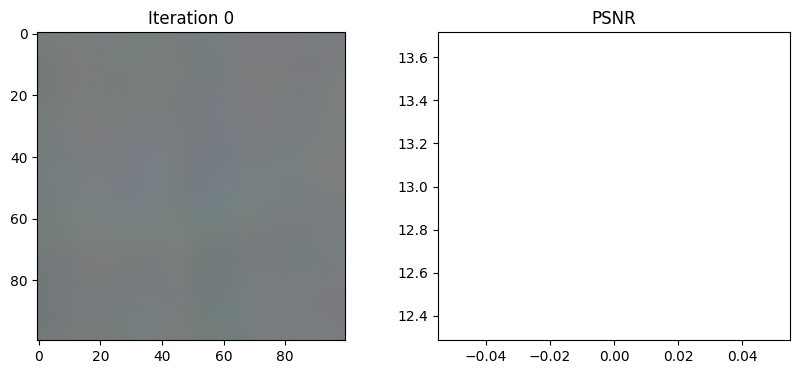

KeyboardInterrupt: 

In [5]:
for i in range(num_iters):

    target_img_idx = np.random.randint(images.shape[0])
    target_pose = poses[target_img_idx].to(device)
    R = target_pose[:3, :3]

    # Get rotated ray origins (ray_origin) and ray directions (ray_dir)
    ray_dir = torch.einsum("ij,hwj->hwi", R, init_ray_dir)
    ray_origin = (R @ init_o).expand(ray_dir.shape)

    # Sample a batch of rays.
    pix_idxs = pixel_ps.multinomial(n_batch_pix, False)
    pix_idx_rows = pix_idxs // img_size
    pix_idx_cols = pix_idxs % img_size
    ray_dir_batch = ray_dir[pix_idx_rows, pix_idx_cols].reshape(
        batch_img_size, batch_img_size, -1
    )
    ray_origin_batch = ray_origin[pix_idx_rows, pix_idx_cols].reshape(
        batch_img_size, batch_img_size, -1
    )

    # Run NeRF.
    (C_rs_c, C_rs_f) = run_nerf(
        ray_dir_batch,
        N_c,
        t_i_c_bin_edges,
        t_i_c_gap,
        ray_origin_batch,
        chunk_size,
        F_c,
        N_f,
        t_f,
        F_f,
    )
    target_img = images[target_img_idx].to(device)
    target_img_batch = target_img[pix_idx_rows, pix_idx_cols].reshape(C_rs_f.shape)

    loss = criterion(C_rs_c, target_img_batch) + criterion(C_rs_f, target_img_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    for g in optimizer.param_groups:
        g["lr"] = lr * decay_rate ** (i / decay_steps)

    if i % display_every == 0:
        F_c.eval()
        F_f.eval()
        with torch.no_grad():
            (_, C_rs_f) = run_nerf(
                test_ray_dir,
                N_c,
                t_i_c_bin_edges,
                t_i_c_gap,
                test_ray_origin,
                chunk_size,
                F_c,
                N_f,
                t_f,
                F_f,
            )

        loss = criterion(C_rs_f, test_img)
        print(f"Loss: {loss.item()}")
        psnr = -10.0 * torch.log10(loss)

        psnrs.append(psnr.item())
        iternums.append(i)

        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(C_rs_f.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.show()

        F_c.train()
        F_f.train()
